In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter


## Splitting data into Train and Test

In [2]:
prepeocessed_data = pd.read_csv('preprocessed_data.csv', nrows=50000)
prepeocessed_data.head(2)

Unnamed: 0  Unnamed: 0.1       id                        teacher_id  \
0           0          8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5   
1           1         37728  p043609  3f60494c61921b3b43ab61bdde2904df   

  teacher_prefix school_state                 Date project_grade_category  \
0            MRS           CA  2016-04-27 00:27:36          Grades_PreK_2   
1             MS           UT  2016-04-27 00:31:25             Grades_3_5   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  ...  \
0  I have been fortunate enough to use the Fairy ...  ...   
1  Imagine being 8-9 years old. You're in your th...  ...   

                                     project_essay_3  \
0  Each month I try to do several science or STEM...   
1  It is tough to do more than one thing at a tim...   

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   
1  When my students are able to calm themselves d...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                           53                    1   
1                                            4                    1   

   clean_categories                 clean_subcategories  \
0      Math_Science  AppliedSciences Health_LifeScience   
1      SpecialNeeds                        SpecialNeeds   

                                               essay   price  quantity  
0  I have been fortunate enough to use the Fairy ...  725.05         4  
1  Imagine being 8-9 years old. You're in your th...  213.03         8  

[2 rows x 21 columns]

In [3]:
y = prepeocessed_data['project_is_approved'].values
X = prepeocessed_data.drop(['project_is_approved'], axis=1)
X.shape

(50000, 20)

In [4]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_test.shape

(16500, 20)

In [5]:
X_train.head(2)

Unnamed: 0  Unnamed: 0.1       id                        teacher_id  \
43676       43676        152262  p203367  640c72932c7413d6be631a3d4ea627f1   
29172       29172         10691  p232099  b28a2c98d6bc923c6ad67045c4c70d35   

      teacher_prefix school_state                 Date project_grade_category  \
43676             MS           TN  2016-09-04 10:55:00            Grades_9_12   
29172             MS           WA  2016-08-13 15:41:07          Grades_PreK_2   

                                           project_title  \
43676                    Science Books for Hungry Minds!   
29172  Developing Language and Creativity Through Ima...   

                                         project_essay_1  \
43676  Raul (name changed for privacy) is a 17-year o...   
29172  The Kindergarten students in my classroom are ...   

                                         project_essay_2 project_essay_3  \
43676  As you can see, the typical student that arriv...             NaN   
29172  Imaginative play is an integral part of educat...             NaN   

      project_essay_4                           project_resource_summary  \
43676             NaN  My students need science books for our Environ...   
29172             NaN  My students need community helper costumes, di...   

       teacher_number_of_previously_posted_projects  \
43676                                             6   
29172                                             4   

                        clean_categories       clean_subcategories  \
43676     Literacy_Language Math_Science  ESL EnvironmentalScience   
29172  Literacy_Language AppliedLearning      ESL EarlyDevelopment   

                                                   essay   price  quantity  
43676  Raul (name changed for privacy) is a 17-year o...  466.41        34  
29172  The Kindergarten students in my classroom are ...  434.89        11

In [6]:
y_train

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [7]:
X_test.head(2)

Unnamed: 0  Unnamed: 0.1       id                        teacher_id  \
33818       33818        105887  p186644  71409aabf3bacfdfff94ca510c5c8476   
6140         6140        101178  p020768  34b27c2f81c204041ca52eb54caf8b68   

      teacher_prefix school_state                 Date project_grade_category  \
33818             MS           MO  2016-08-21 19:49:49          Grades_PreK_2   
6140             MRS           NC  2016-05-29 16:41:03          Grades_PreK_2   

                                           project_title  \
33818  \"...As Ink Flows Freely, the Next Chapter... ...   
6140                                 Wiggle,Wiggle Worm!   

                                         project_essay_1  \
33818  “Oil may run out, liquidity may dry up, but as...   
6140   A typical day in my first grade classroom with...   

                                         project_essay_2 project_essay_3  \
33818  I would like to get my young students comforta...             NaN   
6140   My little owls would  love to have these wobbl...             NaN   

      project_essay_4                           project_resource_summary  \
33818             NaN  My students need ink cartridges for our classr...   
6140              NaN  My students need these wobble chairs so that t...   

       teacher_number_of_previously_posted_projects   clean_categories  \
33818                                            43  Literacy_Language   
6140                                              5  Literacy_Language   

      clean_subcategories                                              essay  \
33818  Literature_Writing  “Oil may run out, liquidity may dry up, but as...   
6140             Literacy  A typical day in my first grade classroom with...   

        price  quantity  
33818  124.16        11  
6140    69.95         6

In [8]:
y_test

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

## 1.4 Encoding Categorical and Numerical features

### 1.4.1 encoding categorical features: clean_categories

In [9]:
vectorizer_cat = CountVectorizer()
vectorizer_cat.fit(X_train['clean_categories'].values) # fit has to happen only on train data

X_train_cc_ohe = vectorizer_cat.transform(X_train['clean_categories'].values)
X_test_cc_ohe = vectorizer_cat.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_cc_ohe.shape, y_train.shape)
print(X_test_cc_ohe.shape, y_test.shape)
print(vectorizer_cat.get_feature_names())

After vectorizations
(33500, 7) (33500,)
(16500, 7) (16500,)
['appliedlearning', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds']


### 1.4.2 encoding categorical features: clean_subcategories

In [10]:
vectorizer_subcat = CountVectorizer()
vectorizer_subcat.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

X_train_csc_ohe = vectorizer_subcat.transform(X_train['clean_subcategories'].values)
X_test_csc_ohe = vectorizer_subcat.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_csc_ohe.shape, y_train.shape)
print(X_test_csc_ohe.shape, y_test.shape)
print(vectorizer_subcat.get_feature_names())

After vectorizations
(33500, 28) (33500,)
(16500, 28) (16500,)
['appliedsciences', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts']


### 1.4.3 encoding categorical features: school_state

In [11]:
vectorizer_school_state = CountVectorizer()
vectorizer_school_state.fit(X_train['school_state'].values) 

X_train_state_ohe = vectorizer_school_state.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer_school_state.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer_school_state.get_feature_names())

After vectorizations
(33500, 51) (33500,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### 1.4.4 encoding categorical features: teacher_prefix

In [12]:
vectorizer_prefix = CountVectorizer()
vectorizer_prefix.fit(X_train['teacher_prefix'].values)

X_train_teacher_ohe = vectorizer_prefix.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_prefix.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer_prefix.get_feature_names())

After vectorizations
(33500, 5) (33500,)
(16500, 5) (16500,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


### 1.4.5 encoding categorical features: project_grade_category

In [13]:
vectorizer_grade = CountVectorizer()
vectorizer_grade.fit(X_train['project_grade_category'].values) 

X_train_grade_ohe = vectorizer_grade.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer_grade.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer_grade.get_feature_names())

After vectorizations
(33500, 4) (33500,)
(16500, 4) (16500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


### 1.4.6 encoding numerical features: price

In [14]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1)).reshape(-1,1)
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print(X_train_price_norm)
print(X_test_price_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00537419]
 [0.005011  ]
 [0.00511608]
 ...
 [0.00206252]
 [0.00667761]
 [0.00377337]]
[[0.00188648]
 [0.00106282]
 [0.0093107 ]
 ...
 [0.00853019]
 [0.02930259]
 [0.00461425]]


### 1.4.7 encoding numerical features: teacher_number_of_previously_posted_projects

In [15]:

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_ppp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
X_test_ppp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_ppp_norm.shape, y_train.shape)
print(X_test_ppp_norm.shape, y_test.shape)
print(X_train_ppp_norm)
print(X_test_ppp_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00124794]
 [0.00083196]
 [0.00041598]
 ...
 [0.00062397]
 [0.00166392]
 [0.        ]]
[[0.01365105]
 [0.00158733]
 [0.00031747]
 ...
 [0.        ]
 [0.00031747]
 [0.00031747]]


### 1.4.8 encoding numerical features: quantity

In [16]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['quantity'].values.reshape(1,-1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(1,-1)).reshape(-1,1)
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print(X_train_quantity_norm)
print(X_test_quantity_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.0056184 ]
 [0.00181772]
 [0.00033049]
 ...
 [0.00033049]
 [0.00644463]
 [0.00495741]]
[[0.00253953]
 [0.0013852 ]
 [0.00692598]
 ...
 [0.00092346]
 [0.00046173]
 [0.00023087]]


### 1.4.9 encoding numerical features: sentiment score's of each of the essay

In [17]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
ss_train = []
ss_test = []
for essay in X_train['essay']:
    ss_train.append(sid.polarity_scores(essay)['pos'])
    
for essay in X_test['essay']:
    ss_test.append(sid.polarity_scores(essay)['pos'])

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

print(len(ss_train))
print(len(ss_test))
print(ss_train[7])
print(ss_test[7])

ss_train_array = np.array(ss_train)
ss_test_array = np.array(ss_test)
print(ss_train_array.shape)
print(ss_test_array.shape)

33500
16500
0.142
0.166
(33500,)
(16500,)


In [18]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(ss_train_array.reshape(1,-1))

X_train_ss_norm = normalizer.transform(ss_train_array.reshape(1,-1)).reshape(-1,1)
X_test_ss_norm = normalizer.transform(ss_test_array.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_ss_norm.shape, y_train.shape)
print(X_test_ss_norm.shape, y_test.shape)
print(X_train_ss_norm)
print(X_test_ss_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00164784]
 [0.00521317]
 [0.00368517]
 ...
 [0.00560266]
 [0.00590227]
 [0.00755011]]
[[0.00870842]
 [0.00700088]
 [0.01054401]
 ...
 [0.00751314]
 [0.00307356]
 [0.00426883]]


### 1.4.10 encoding numerical features: number of words in the title

In [19]:
title_word_count_train = []
title_word_count_test = []


for i in X_train['project_title']:
    title_word_count_train.append(len(i.split()))

for i in X_test['project_title']:
    title_word_count_test.append(len(i.split()))

print(len(title_word_count_train))
print(len(title_word_count_test))
print(title_word_count_train[7])
print(title_word_count_train[7])

title_word_count_train_array = np.array(title_word_count_train)
title_word_count_test_array = np.array(title_word_count_test)
print(title_word_count_train_array.shape)
print(title_word_count_test_array.shape)

33500
16500
3
3
(33500,)
(16500,)


In [20]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(title_word_count_train_array.reshape(1,-1))

X_train_twc_norm = normalizer.transform(title_word_count_train_array.reshape(1,-1)).reshape(-1,1)
X_test_twc_norm = normalizer.transform(title_word_count_test_array.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_twc_norm.shape, y_train.shape)
print(X_test_twc_norm.shape, y_test.shape)
print(X_train_twc_norm)
print(X_test_twc_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00486319]
 [0.00680847]
 [0.00194528]
 ...
 [0.00291792]
 [0.00486319]
 [0.00389055]]
[[0.01387776]
 [0.00277555]
 [0.01110221]
 ...
 [0.00277555]
 [0.00971443]
 [0.00693888]]


### 1.4.11 encoding numerical features: number of words in the combine essays

In [21]:
essay_word_count_train = []
essay_word_count_test = []
for i in X_train['essay']:
    essay_word_count_train.append(len(i.split()))


for i in X_test['essay']:
    essay_word_count_test.append(len(i.split()))

print(len(essay_word_count_train))
print(len(essay_word_count_test))
print(essay_word_count_train[7])
print(essay_word_count_test[7])


essay_word_count_train_array = np.array(essay_word_count_train)
essay_word_count_test_array = np.array(essay_word_count_test)
print(essay_word_count_train_array.shape)
print(essay_word_count_test_array.shape)

33500
16500
199
276
(33500,)
(16500,)


In [22]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(essay_word_count_train_array.reshape(1,-1))

X_train_ewc_norm = normalizer.transform(essay_word_count_train_array.reshape(1,-1)).reshape(-1,1)
X_test_ewc_norm = normalizer.transform(essay_word_count_test_array.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_ewc_norm.shape, y_train.shape)
print(X_test_ewc_norm.shape, y_test.shape)
print(X_train_ewc_norm)
print(X_test_ewc_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00624041]
 [0.00973913]
 [0.00495141]
 ...
 [0.00497187]
 [0.00744757]
 [0.00368286]]
[[0.01184383]
 [0.00778893]
 [0.0070888 ]
 ...
 [0.00568854]
 [0.0129232 ]
 [0.00860574]]


## 1.5 Vectorizing Text features

### 1.5.1 Vectorizing using BOW 

#### Essay

In [23]:

print(X_train.shape, y_train.shape)
#print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("\n\n")


vectorizer_bow_essay = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow_essay.fit(X_train['essay'].values) # fit has to happen only on train data

X_train_essay_bow = vectorizer_bow_essay.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer_bow_essay.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)


(33500, 20) (33500,)
(16500, 20) (16500,)



After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


#### project_title

In [24]:
vectorizer_bow_title = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow_title.fit(X_train['project_title'].values) # fit has to happen only on train data


X_train_titles_bow = vectorizer_bow_title.transform(X_train['project_title'].values)
X_test_titles_bow = vectorizer_bow_title.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_titles_bow.shape, y_train.shape)
print(X_test_titles_bow.shape, y_test.shape)

After vectorizations
(33500, 4021) (33500,)
(16500, 4021) (16500,)


#### project_resource_summary

In [25]:
vectorizer_bow_rs = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow_rs.fit(X_train['project_resource_summary'].values) # fit has to happen only on train data


X_train_psr_bow = vectorizer_bow_rs.transform(X_train['project_resource_summary'].values)
X_test_psr_bow = vectorizer_bow_rs.transform(X_test['project_resource_summary'].values)

print("After vectorizations")
print(X_train_psr_bow.shape, y_train.shape)
print(X_test_psr_bow.shape, y_test.shape)

After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


### 1.5.2 Vectorizing using TFIDF

#### essay

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf_essay.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer_tfidf_essay.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer_tfidf_essay.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


#### project_title

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_title = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf_title.fit(X_train['project_title'].values)

X_train_titles_tfidf = vectorizer_tfidf_title.transform(X_train['project_title'].values)
X_test_titles_tfidf = vectorizer_tfidf_title.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_titles_tfidf.shape, y_train.shape)
print(X_test_titles_tfidf.shape, y_test.shape)

After vectorizations
(33500, 4021) (33500,)
(16500, 4021) (16500,)


#### project_resource_summary

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_rs = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf_rs.fit(X_train['project_resource_summary'].values)

X_train_prs_tfidf = vectorizer_tfidf_rs.transform(X_train['project_resource_summary'].values)
X_test_prs_tfidf = vectorizer_tfidf_rs.transform(X_test['project_resource_summary'].values)

print("After vectorizations")
print(X_train_prs_tfidf.shape, y_train.shape)
print(X_test_prs_tfidf.shape, y_test.shape)

After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


### 1.5.3 Vectorizing using AVG W2V

In [29]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

#### essay

In [30]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_essay_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay_train.append(vector)

print(len(avg_w2v_essay_train))
print(len(avg_w2v_essay_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 33500/33500 [00:11<00:00, 2936.78it/s]

33500
300


In [31]:
avg_w2v_essay_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay_test.append(vector)

100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:05<00:00, 2921.46it/s]


#### project_title

In [32]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_titles_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_titles_train.append(vector)

print(len(avg_w2v_titles_train))
print(len(avg_w2v_titles_train[0]))


100%|████████████████████████████████████████████████████████████████████████| 33500/33500 [00:00<00:00, 150303.57it/s]

33500
300


In [33]:
avg_w2v_titles_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_titles_test.append(vector)

100%|████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 149750.22it/s]


#### project_resource_summary

In [34]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_prs_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_resource_summary'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_prs_train.append(vector)

print(len(avg_w2v_prs_train))
print(len(avg_w2v_prs_train[0]))


100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:01<00:00, 32433.97it/s]

33500
300


In [35]:
avg_w2v_prs_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_resource_summary'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_prs_test.append(vector)

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 31332.09it/s]


### 1.5.4 Vectorizing using TFIDF W2V

#### project_title

In [36]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

print(len(tfidf_w2v_title_train))
print(len(tfidf_w2v_title_train[0]))

100%|████████████████████████████████████████████████████████████████████████| 33500/33500 [00:00<00:00, 100878.69it/s]

33500
300


In [37]:
tfidf_w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)

print(len(tfidf_w2v_title_test))
print(len(tfidf_w2v_title_test[0]))

100%|████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 100250.77it/s]

16500
300


#### essay

In [38]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_essay_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essay_train.append(vector)

print(len(tfidf_w2v_essay_train))
print(len(tfidf_w2v_essay_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 33500/33500 [02:19<00:00, 240.81it/s]

33500
300


In [39]:
tfidf_w2v_essay_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essay_test.append(vector)

print(len(tfidf_w2v_essay_test))
print(len(tfidf_w2v_essay_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [01:07<00:00, 243.23it/s]

16500
300


#### project_resource_summary

In [40]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['project_resource_summary'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_prs_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_resource_summary']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_prs_train.append(vector)

print(len(tfidf_w2v_prs_train))
print(len(tfidf_w2v_prs_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:03<00:00, 10774.89it/s]

33500
300


In [41]:
tfidf_w2v_prs_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_resource_summary']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_prs_test.append(vector)

print(len(tfidf_w2v_prs_test))
print(len(tfidf_w2v_prs_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:01<00:00, 10780.64it/s]

16500
300


### Merging all the categorical and numerical features with variations of text features

In [42]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_bow_matrix = hstack((X_train_cc_ohe, X_train_csc_ohe, X_train_grade_ohe, X_train_state_ohe, 
                             X_train_teacher_ohe, X_train_price_norm, X_train_ppp_norm, 
                             X_train_ewc_norm, X_train_twc_norm, X_train_ss_norm, X_train_quantity_norm,
                             X_train_essay_bow, X_train_titles_bow, X_train_psr_bow)).tocsr()


X_test_bow_matrix = hstack((X_test_cc_ohe, X_test_csc_ohe, X_test_grade_ohe, X_test_state_ohe, 
                            X_test_teacher_ohe, X_test_price_norm, X_test_ppp_norm, 
                            X_test_ewc_norm, X_test_twc_norm, X_test_ss_norm, X_test_quantity_norm,
                            X_test_essay_bow, X_test_titles_bow, X_test_psr_bow)).tocsr()

print("Final Data matrix")
print(X_train_bow_matrix.shape, y_train.shape)
print(X_test_bow_matrix.shape, y_test.shape)

Final Data matrix
(33500, 14122) (33500,)
(16500, 14122) (16500,)


In [43]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_tfidf_matrix = hstack((X_train_cc_ohe, X_train_csc_ohe, X_train_grade_ohe, X_train_state_ohe, 
                             X_train_teacher_ohe, X_train_price_norm, X_train_ppp_norm, 
                             X_train_ewc_norm, X_train_twc_norm, X_train_ss_norm, X_train_quantity_norm,
                             X_train_titles_tfidf, X_train_essay_tfidf, X_train_prs_tfidf)).tocsr()

X_test_tfidf_matrix = hstack((X_test_cc_ohe, X_test_csc_ohe, X_test_grade_ohe, X_test_state_ohe, 
                            X_test_teacher_ohe, X_test_price_norm, X_test_ppp_norm, 
                            X_test_ewc_norm, X_test_twc_norm, X_test_ss_norm, X_test_quantity_norm,
                            X_test_titles_tfidf, X_test_essay_tfidf, X_test_prs_tfidf)).tocsr()

print("Final Data matrix")
print(X_train_tfidf_matrix.shape, y_train.shape)
print(X_test_tfidf_matrix.shape, y_test.shape)


Final Data matrix
(33500, 14122) (33500,)
(16500, 14122) (16500,)


In [44]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_aw2v_matrix = hstack((X_train_cc_ohe, X_train_csc_ohe, X_train_grade_ohe, X_train_state_ohe, 
                             X_train_teacher_ohe, X_train_price_norm, X_train_ppp_norm,
                             X_train_ewc_norm, X_train_twc_norm, X_train_ss_norm, X_train_quantity_norm,
                             avg_w2v_essay_train, avg_w2v_titles_train, avg_w2v_prs_train)).tocsr()

X_test_aw2v_matrix = hstack((X_test_cc_ohe, X_test_csc_ohe, X_test_grade_ohe, X_test_state_ohe, 
                            X_test_teacher_ohe, X_test_price_norm, X_test_ppp_norm, 
                            X_test_ewc_norm, X_test_twc_norm, X_test_ss_norm, X_test_quantity_norm,
                            avg_w2v_essay_test, avg_w2v_titles_test, avg_w2v_prs_test)).tocsr()

print("Final Data matrix")
print(X_train_aw2v_matrix.shape, y_train.shape)
print(X_test_aw2v_matrix.shape, y_test.shape)

Final Data matrix
(33500, 1001) (33500,)
(16500, 1001) (16500,)


In [45]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_tw2v_matrix = hstack((X_train_cc_ohe, X_train_csc_ohe, X_train_grade_ohe, X_train_state_ohe, 
                             X_train_teacher_ohe, X_train_price_norm, X_train_ppp_norm,
                             X_train_ewc_norm, X_train_twc_norm, X_train_ss_norm, X_train_quantity_norm, 
                             tfidf_w2v_essay_train, tfidf_w2v_title_train, tfidf_w2v_prs_train)).tocsr()

X_test_tw2v_matrix = hstack((X_test_cc_ohe, X_test_csc_ohe, X_test_grade_ohe, X_test_state_ohe, 
                            X_test_teacher_ohe, X_test_price_norm, X_test_ppp_norm, 
                            X_test_ewc_norm, X_test_twc_norm, X_test_ss_norm, X_test_quantity_norm,
                            tfidf_w2v_essay_test, tfidf_w2v_title_test, tfidf_w2v_prs_test)).tocsr()

print("Final Data matrix")
print(X_train_tw2v_matrix.shape, y_train.shape)
print(X_test_tw2v_matrix.shape, y_test.shape)

Final Data matrix
(33500, 1001) (33500,)
(16500, 1001) (16500,)


## Finding Best Hyper parameter using K-Fold CV on BOW representation of text features

In [46]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

parameters = {'max_depth' : [2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20], 'min_samples_split' : [10, 50, 100, 250, 500]}
dtc = DecisionTreeClassifier(class_weight =  "balanced")
clf = GridSearchCV(dtc, parameters, cv=5, scoring='roc_auc', return_train_score=True,  n_jobs = -1)
clf.fit(X_train_bow_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_min_samples_split']


results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.712000      0.047273         0.040116        0.008381   
1        1.692217      0.064606         0.039741        0.008219   
2        1.741809      0.033066         0.055598        0.005515   
3        1.804599      0.085000         0.039574        0.009951   
4        1.781371      0.080513         0.041194        0.007006   
5        3.042189      0.093215         0.031989        0.003831   
6        2.837882      0.173126         0.037968        0.009190   
7        2.600964      0.079851         0.033000        0.002107   
8        2.550824      0.185863         0.035811        0.006377   
9        2.793291      0.297218         0.037035        0.008822   
14       4.321465      0.111620         0.033812        0.003710   
12       4.714063      0.212692         0.038400        0.003911   
13       4.616745      0.238316         0.032730        0.002938   
10       5.182484      0.280443         0.033585        0.005428   
11       4.765838      0.253262         0.044388        0.012248   
15       9.393574      0.348405         0.030948        0.002085   
16       8.474054      0.393189         0.034741        0.004288   
17       8.208085      0.544576         0.032421        0.002175   
18       7.366438      0.237003         0.032522        0.003195   
19       6.344825      0.302522         0.031367        0.003715   
20      12.299228      0.542616         0.031538        0.002959   
21      10.917348      0.591823         0.033467        0.006661   
22      10.189388      0.676517         0.032419        0.001604   
23       9.103482      0.088079         0.033241        0.003931   
24       7.548348      0.395079         0.032136        0.003969   
29       8.684676      0.375675         0.030823        0.001283   
28      10.448293      0.221518         0.030829        0.003088   
27      12.227570      0.606614         0.038849        0.005192   
26      13.421934      0.474552         0.032936        0.006183   
25      15.293760      0.827720         0.030058        0.000892   
30      21.723988      0.820570         0.033237        0.004819   
31      18.419320      0.730817         0.033096        0.005603   
32      16.017952      0.637246         0.037532        0.005115   
33      13.446887      0.222723         0.031256        0.002894   
34      10.536583      0.395302         0.033573        0.002170   
35      27.327498      0.938933         0.033403        0.005028   
36      22.684766      1.016089         0.031844        0.002271   
37      19.609827      1.100847         0.031237        0.001634   
38      16.098375      0.338923         0.029577        0.000505   
39      12.279568      0.473833         0.029512        0.000603   
44      14.201966      0.398768         0.031719        0.001500   
43      18.509045      0.206608         0.031438        0.001979   
41      26.293795      1.373305         0.033744        0.004171   
40      32.246592      1.173069         0.037925        0.003313   
42      22.779964      0.737612         0.034378        0.003949   
45      37.081958      1.235064         0.031715        0.001716   
46      29.285612      1.446627         0.030972        0.002503   
47      25.228605      0.998517         0.032513        0.001197   
48      20.424279      0.496046         0.031320        0.002861   
49      15.484301      0.660383         0.031715        0.002221   
53      18.954226      1.928009         0.025214        0.011913   
50      40.320490      1.264861         0.032066        0.002149   
51      32.184636      1.118569         0.029024        0.001425   
52      27.611694      1.052559         0.032314        0.003253   
54      13.373901      0.424564         0.020270        0.003513   

   param_max_depth param_min_samples_split  \
0                2                      10   
1                2                      50   
2                2                     100   
3          

In [47]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'min_samples_split'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

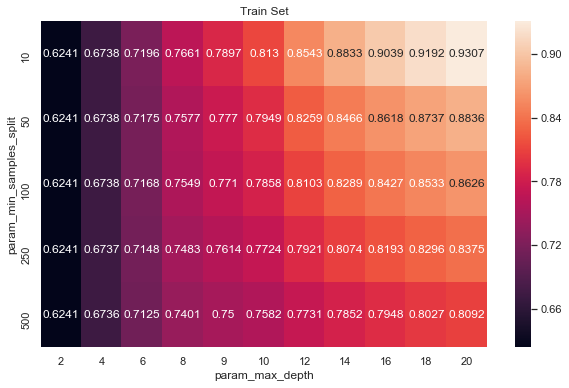

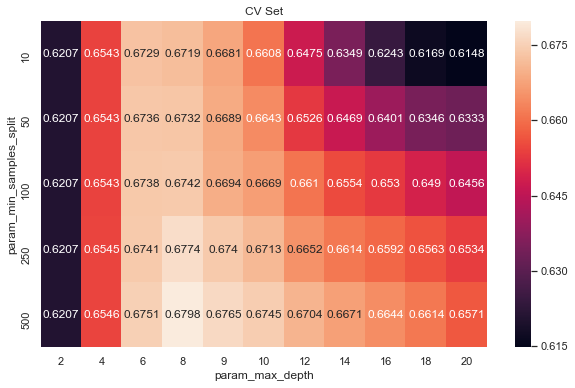

In [48]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [49]:
best_max_depth_bow = clf.best_params_['max_depth']
best_min_samples_split_bow = clf.best_params_['min_samples_split']
print('best value for max depth is {} and best value for min samples split is {}'.format(best_max_depth_bow,best_min_samples_split_bow))

best value for max depth is 8 and best value for min samples split is 500


## Finding Best Hyper parameter using K-Fold CV on TFIDF representation of text features

In [50]:
parameters = {'max_depth' : [2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20], 'min_samples_split' : [10, 50, 100, 250, 500]}
dtc = DecisionTreeClassifier(class_weight =  "balanced")
clf = GridSearchCV(dtc, parameters, cv=5, scoring='roc_auc', return_train_score=True,  n_jobs = -1)
clf.fit(X_train_bow_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_min_samples_split']


In [51]:
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.629803      0.023339         0.032912        0.003337   
1        1.770487      0.166434         0.050278        0.015584   
2        1.769947      0.159036         0.050966        0.021474   
3        1.829452      0.177473         0.046276        0.025393   
4        1.771495      0.143192         0.041302        0.010763   
5        3.018827      0.368824         0.038997        0.013733   
6        2.675098      0.162207         0.037243        0.005100   
7        2.622925      0.169199         0.041222        0.005557   
8        2.550089      0.202031         0.034771        0.001012   
9        2.508759      0.136906         0.035593        0.002712   
14       4.328965      0.156390         0.040833        0.007586   
12       4.604586      0.183159         0.042220        0.004458   
13       4.878407      0.280349         0.036314        0.004271   
10       5.500923      0.320403         0.038174        0.015443   
11       5.132353      0.378372         0.037510        0.006092   
15       9.858148      0.641831         0.031456        0.001968   
16       9.210586      0.673312         0.038427        0.006353   
17       8.725493      0.644093         0.039758        0.007902   
18       7.578480      0.396156         0.032904        0.002444   
19       6.604784      0.241291         0.033480        0.001235   
20      12.372719      0.627311         0.033658        0.006728   
21      11.523348      0.747454         0.032050        0.002587   
22      10.910704      0.615809         0.038536        0.003522   
23       9.100117      0.555012         0.034237        0.005657   
24       7.842560      0.528720         0.031568        0.003451   
29       8.949695      0.477474         0.033430        0.003114   
28      10.851177      0.628963         0.038577        0.011895   
27      12.771473      0.551207         0.045013        0.016273   
26      13.760736      0.366970         0.031969        0.001852   
25      16.260358      0.955190         0.035682        0.002120   
30      22.880302      1.634233         0.034674        0.005475   
31      19.365457      1.162769         0.032972        0.001389   
32      16.604177      1.077183         0.043257        0.007872   
33      13.943589      0.240236         0.032691        0.004078   
34      11.125195      0.832793         0.031865        0.004145   
35      28.766423      1.764920         0.032443        0.001598   
36      23.838205      1.178401         0.036551        0.005408   
37      20.200323      1.265524         0.035462        0.001925   
38      16.562765      0.848995         0.031734        0.002090   
39      13.055334      0.724048         0.034482        0.005853   
44      14.598019      0.967374         0.033438        0.003676   
43      19.340676      0.735289         0.033788        0.005286   
41      27.893325      1.355642         0.030718        0.000746   
40      33.417320      1.102479         0.038811        0.005967   
42      23.264381      1.281768         0.041467        0.005077   
45      38.147593      1.248749         0.031617        0.001533   
46      30.275039      1.079235         0.034081        0.006081   
47      26.344856      1.228744         0.036443        0.004266   
48      21.284501      0.766629         0.037311        0.007283   
49      16.451888      0.645466         0.032426        0.003094   
53      19.670429      2.164067         0.021593        0.005201   
50      41.331626      1.807305         0.035565        0.004030   
51      33.593528      0.620118         0.028834        0.000907   
52      28.864724      0.857127         0.040105        0.011048   
54      13.618413      0.640425         0.017956        0.000631   

   param_max_depth param_min_samples_split  \
0                2                      10   
1                2                      50   
2                2                     100   
3          

In [52]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'min_samples_split'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

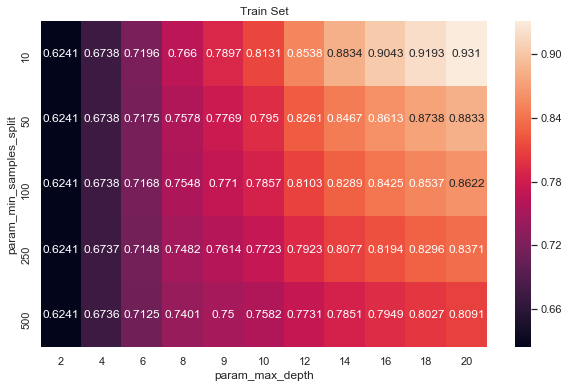

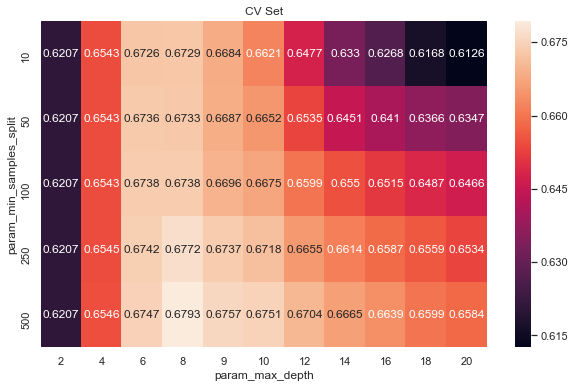

In [53]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [54]:
best_max_depth_tfidf = clf.best_params_['max_depth']
best_min_samples_split_tfidf = clf.best_params_['min_samples_split']
print('best value for max depth is {} and best value for min samples split is {}'.format(best_max_depth_tfidf,best_min_samples_split_tfidf))

best value for max depth is 8 and best value for min samples split is 500


## Finding Best Hyper parameter using K-Fold CV on AVG W2V representation of text features

In [55]:
parameters = {'max_depth' : [2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20], 'min_samples_split' : [10, 50, 100, 250, 500]}
dtc = DecisionTreeClassifier(class_weight =  "balanced")
clf = GridSearchCV(dtc, parameters, cv=5, scoring='roc_auc', return_train_score=True,  n_jobs = -1)
clf.fit(X_train_aw2v_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_min_samples_split']
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        9.073709      0.395961         0.101467        0.049019   
1        8.991551      0.074362         0.081228        0.008158   
2        9.169541      0.292204         0.117928        0.024518   
3        9.075585      0.355840         0.068065        0.016601   
4        9.151557      0.362674         0.090862        0.023539   
5       16.882113      0.518464         0.070826        0.019919   
6       15.796281      0.425261         0.066727        0.015294   
7       15.511238      0.497821         0.062690        0.004457   
8       15.803764      0.555497         0.073843        0.025476   
9       15.917420      0.699245         0.063180        0.008039   
14      24.149763      0.552122         0.064858        0.007734   
12      25.752425      0.574766         0.071128        0.017503   
13      25.340185      0.651199         0.064502        0.013872   
10      26.167474      1.007091         0.069112        0.013888   
11      26.131839      0.670297         0.064907        0.006348   
15      41.578129      0.675220         0.060979        0.002516   
16      41.020239      0.703036         0.057528        0.003554   
17      41.027741      1.316291         0.059071        0.005371   
18      36.542462      1.158737         0.061197        0.003341   
19      33.007369      0.999711         0.067220        0.012269   
20      50.025982      2.148165         0.062357        0.005087   
21      50.737449      1.410241         0.060833        0.003449   
22      49.077393      1.983225         0.068055        0.007989   
23      42.211749      1.086136         0.067663        0.007325   
24      35.259457      1.160320         0.063612        0.003582   
29      37.585175      1.111373         0.061971        0.007952   
28      46.728469      1.064694         0.067079        0.005947   
27      56.186645      2.311693         0.061912        0.004290   
26      58.945077      1.912954         0.068409        0.010405   
25      58.599491      2.369658         0.058709        0.003958   
30      72.115395      1.223830         0.064214        0.004604   
31      70.330179      1.636779         0.059654        0.006058   
32      65.941272      0.815097         0.062035        0.008878   
33      53.250276      1.575735         0.061753        0.003013   
34      41.359940      1.387169         0.057618        0.002670   
35      81.866140      1.191163         0.063333        0.002818   
36      77.701673      1.500228         0.059863        0.004780   
37      74.925213      0.806417         0.066230        0.011628   
38      58.807966      1.654149         0.061841        0.003605   
39      42.763129      1.106002         0.061933        0.007173   
44      44.369890      2.097717         0.060239        0.003710   
43      60.228367      1.045803         0.068417        0.014392   
41      83.588649      2.503907         0.065824        0.012819   
40      88.174974      1.908874         0.057646        0.002309   
42      78.718920      2.715115         0.058045        0.002309   
45      91.829234      1.747293         0.060039        0.002554   
46      86.868001      1.550088         0.065625        0.012287   
47      83.347412      1.776901         0.060838        0.003278   
48      62.391313      0.833721         0.060438        0.004951   
49      45.165237      2.246049         0.061835        0.003624   
53      56.283331      3.806409         0.045290        0.008930   
50      96.845400      1.835787         0.059242        0.004165   
51      92.197679      2.756371         0.058447        0.002548   
52      86.467478      3.103394         0.053855        0.002821   
54      39.626357      2.777384         0.043893        0.004202   

   param_max_depth param_min_samples_split  \
0                2                      10   
1                2                      50   
2                2                     100   
3          

In [56]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'min_samples_split'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

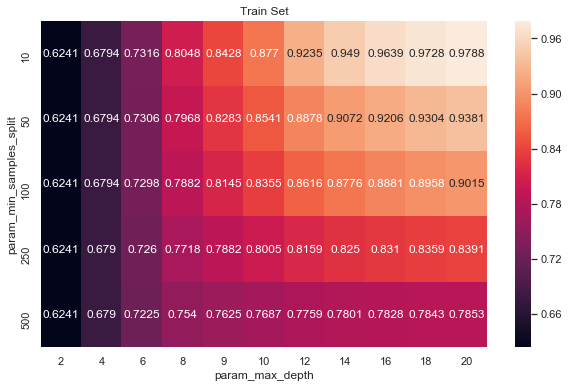

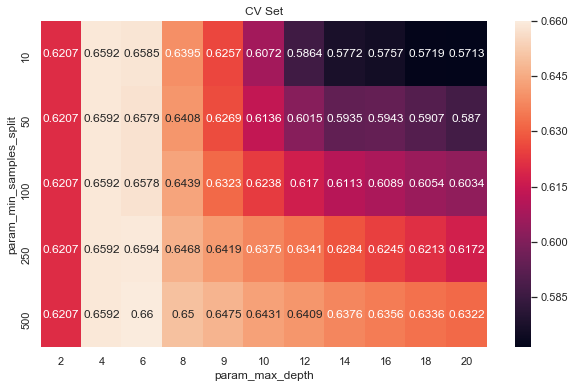

In [57]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [58]:
best_max_depth_aw2v = clf.best_params_['max_depth']
best_min_samples_split_aw2v = clf.best_params_['min_samples_split']
print('best value for max depth is {} and best value for min samples split is {}'.format(best_max_depth_aw2v,best_min_samples_split_aw2v))

best value for max depth is 6 and best value for min samples split is 500


## Finding Best Hyper parameter using K-Fold CV on TFIDF W2V representation of text features

In [59]:
parameters = {'max_depth' : [2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20], 'min_samples_split' : [10, 50, 100, 250, 500]}
dtc = DecisionTreeClassifier(class_weight =  "balanced")
clf = GridSearchCV(dtc, parameters, cv=5, scoring='roc_auc', return_train_score=True,  n_jobs = -1)
clf.fit(X_train_tw2v_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_min_samples_split']
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        8.511832      0.244704         0.069805        0.020916   
1        8.912551      0.307221         0.120678        0.044723   
2        8.749189      0.324302         0.108908        0.040983   
3        8.896416      0.374482         0.066223        0.016101   
4        8.967285      0.365834         0.069623        0.009825   
5       15.669543      0.469683         0.056449        0.004910   
6       15.560355      0.629770         0.065624        0.012415   
7       15.806425      0.665739         0.064330        0.008839   
8       15.312032      0.422217         0.060837        0.008272   
9       15.527009      0.562348         0.074401        0.018124   
14      23.894563      1.003717         0.056848        0.003989   
12      24.885281      0.783003         0.060844        0.007037   
13      24.735900      0.436357         0.064228        0.008117   
10      25.068341      0.597982         0.062233        0.006956   
11      25.281625      0.546696         0.063829        0.005883   
15      38.709595      0.895294         0.057645        0.003051   
16      39.181441      1.015285         0.056050        0.003645   
17      38.894576      0.957293         0.060438        0.003129   
18      36.556256      1.040993         0.064028        0.008063   
19      31.712076      0.347445         0.061635        0.009841   
20      47.776021      0.943622         0.061635        0.005829   
21      46.881659      1.126489         0.063430        0.010143   
22      46.314210      0.789959         0.057846        0.003397   
23      41.235474      0.966136         0.057047        0.002849   
24      34.960794      1.295972         0.055651        0.001163   
29      37.138591      1.471196         0.064102        0.008887   
28      46.082324      0.606327         0.065035        0.002901   
27      53.617741      0.849206         0.064743        0.010758   
26      54.492966      0.846234         0.061937        0.005887   
25      54.925269      0.455173         0.067818        0.008439   
30      70.580368      1.639731         0.061751        0.007681   
31      68.369701      1.914232         0.061126        0.008315   
32      66.021346      1.996526         0.070314        0.011895   
33      52.538050      1.986189         0.063231        0.003602   
34      39.499885      1.604570         0.060837        0.009566   
35      80.312177      0.927990         0.061436        0.002792   
36      77.314813      1.267806         0.060143        0.004822   
37      74.456861      0.915112         0.056050        0.002631   
38      56.695640      1.980840         0.067424        0.015200   
39      40.571143      0.773633         0.057845        0.004592   
44      42.515686      1.310484         0.058533        0.005263   
43      59.622477      1.287118         0.064590        0.007854   
41      81.485423      0.385748         0.060647        0.003963   
40      84.817499      0.931683         0.063231        0.005732   
42      78.643645      2.131508         0.059373        0.002653   
45      92.672061      1.413315         0.061992        0.002976   
46      87.157851      1.603289         0.056089        0.002240   
47      83.326582      1.671764         0.057661        0.003112   
48      61.650929      1.397509         0.057247        0.001739   
49      42.836843      1.095994         0.058063        0.001932   
53      56.169553      4.114041         0.042220        0.006350   
50      94.947975      1.537241         0.060439        0.003710   
51      91.130162      2.579083         0.060838        0.007953   
52      85.259696      2.202318         0.055174        0.002941   
54      37.482802      1.420922         0.046401        0.005939   

   param_max_depth param_min_samples_split  \
0                2                      10   
1                2                      50   
2                2                     100   
3          

In [60]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'min_samples_split'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

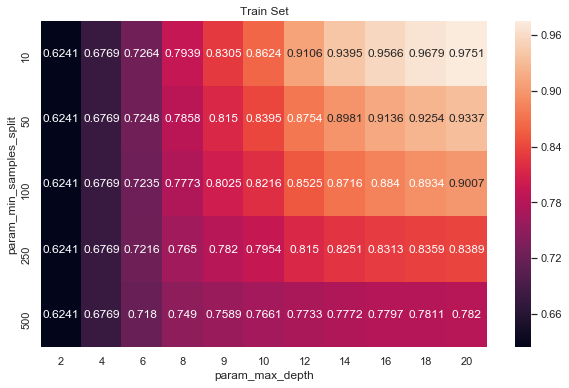

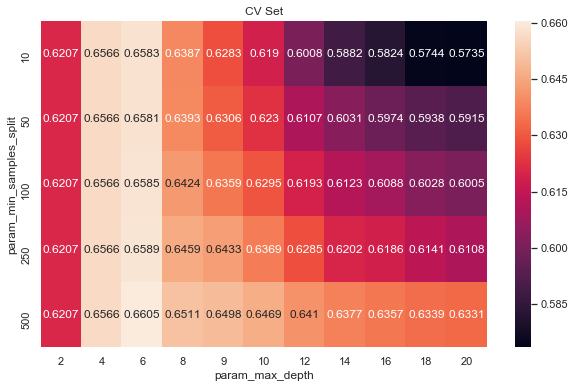

In [61]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [62]:
best_max_depth_tw2v = clf.best_params_['max_depth']
best_min_samples_split_tw2v = clf.best_params_['min_samples_split']
print('best value for max depth is {} and best value for min samples split is {}'.format(best_max_depth_tw2v,best_min_samples_split_tw2v))

best value for max depth is 6 and best value for min samples split is 500


In [63]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [64]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

## Applying Decision Tree with obtained best Hyper parameter on BOW

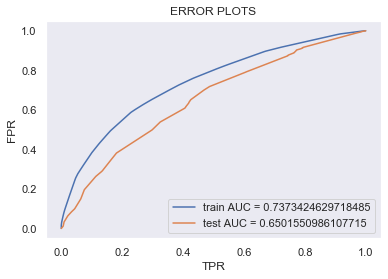

In [65]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
# https://stackoverflow.com/a/57789235
#https://stackoverflow.com/a/56747024

dt = DecisionTreeClassifier(max_depth= best_max_depth_bow, min_samples_split=best_min_samples_split_bow, class_weight =  "balanced")
dt.fit(X_train_bow_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(dt, X_train_bow_matrix)    
y_test_pred = batch_predict(dt, X_test_bow_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for BOW

the maximum value of tpr*(1-fpr) 0.4583446440747752 for threshold 0.476


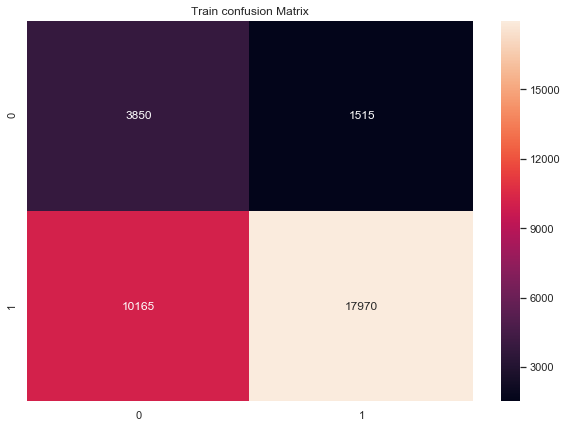

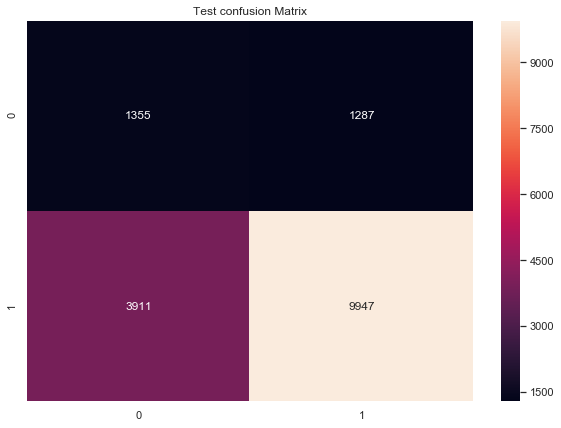

In [66]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247dt

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

In [67]:
bow_features_names = []

for feature in vectorizer_cat.get_feature_names() :
    bow_features_names.append(feature)

for feature in vectorizer_subcat.get_feature_names() :
    bow_features_names.append(feature)

for feature in vectorizer_school_state.get_feature_names() :
    bow_features_names.append(feature)

for feature in vectorizer_grade.get_feature_names() :
    bow_features_names.append(feature)

for feature in vectorizer_prefix.get_feature_names() :
    bow_features_names.append(feature)

for feature in vectorizer_bow_title.get_feature_names() :
    bow_features_names.append(feature)
    
for feature in vectorizer_bow_essay.get_feature_names() :
    bow_features_names.append(feature)
    
for feature in vectorizer_bow_rs.get_feature_names() :
    bow_features_names.append(feature)
    
bow_features_names.append("price")
bow_features_names.append("quantity")
bow_features_names.append("teacher_number_of_previously_posted_projects")
bow_features_names.append('title_word_count')
bow_features_names.append('essay_word_count')
bow_features_names.append('essay_sentiment_score')

print('Number of feature are :',len(bow_features_names))
bow_features_names

Number of feature are : 14122


['appliedlearning',
 'health_sports',
 'history_civics',
 'literacy_language',
 'math_science',
 'music_arts',
 'specialneeds',
 'appliedsciences',
 'charactereducation',
 'civics_government',
 'college_careerprep',
 'communityservice',
 'earlydevelopment',
 'economics',
 'environmentalscience',
 'esl',
 'extracurricular',
 'financialliteracy',
 'foreignlanguages',
 'gym_fitness',
 'health_lifescience',
 'health_wellness',
 'history_geography',
 'literacy',
 'literature_writing',
 'mathematics',
 'music',
 'nutritioneducation',
 'other',
 'parentinvolvement',
 'performingarts',
 'socialsciences',
 'specialneeds',
 'teamsports',
 'visualarts',
 'ak',
 'al',
 'ar',
 'az',
 'ca',
 'co',
 'ct',
 'dc',
 'de',
 'fl',
 'ga',
 'hi',
 'ia',
 'id',
 'il',
 'in',
 'ks',
 'ky',
 'la',
 'ma',
 'md',
 'me',
 'mi',
 'mn',
 'mo',
 'ms',
 'mt',
 'nc',
 'nd',
 'ne',
 'nh',
 'nj',
 'nm',
 'nv',
 'ny',
 'oh',
 'ok',
 'or',
 'pa',
 'ri',
 'sc',
 'sd',
 'tn',
 'tx',
 'ut',
 'va',
 'vt',
 'wa',
 'wi',
 'wv',

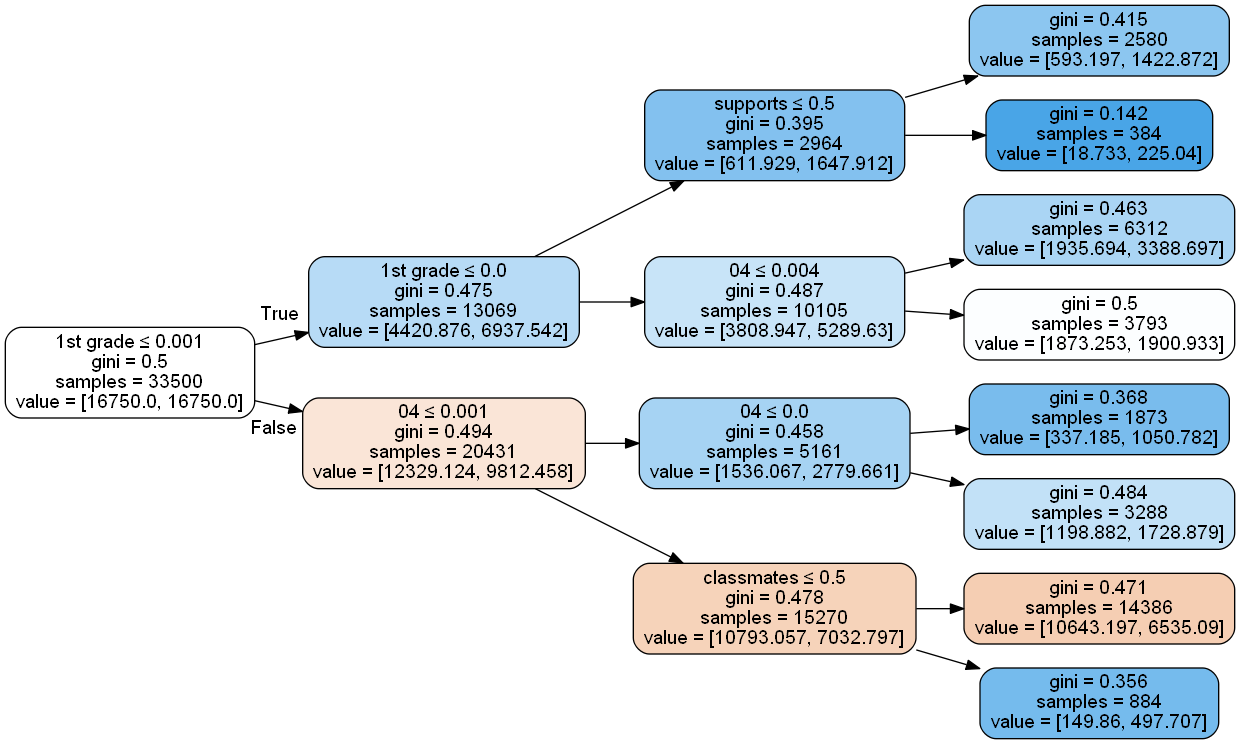

In [68]:
import warnings
import graphviz
warnings.filterwarnings("ignore")
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
from graphviz import Source
import pydotplus

dt = DecisionTreeClassifier(max_depth= 3, min_samples_split=best_min_samples_split_bow, class_weight =  "balanced")
dt.fit(X_train_bow_matrix, y_train)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=bow_features_names,rotate=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [69]:
predictions = predict_with_best_t(y_test_pred,best_t)
len(predictions)

16500

In [70]:
act_vs_predicted = pd.DataFrame({'index' : X_test.index, 'actual_label':y_test,'predicted_label':predictions})
act_vs_predicted.head(20)

index  actual_label  predicted_label
0   33818             1                1
1    6140             1                1
2   11555             1                0
3   23477             1                1
4   31007             1                0
5   49771             1                1
6   20399             1                1
7   35350             1                0
8   44517             1                1
9   33698             1                1
10   6332             1                0
11  15025             1                0
12  44119             1                1
13    496             0                1
14  19356             0                1
15  11569             1                0
16  23147             0                1
17   4775             1                1
18  25411             1                1
19   2472             1                1

In [71]:
false_positives = []
for i in tqdm(range(len(act_vs_predicted))):
    if(act_vs_predicted['actual_label'][i]==0 and act_vs_predicted['predicted_label'][i]==1 ):
        false_positives.append(i)

len(false_positives)

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 72130.55it/s]


1287

In [72]:
false_positives_essay = []
for i in false_positives :
    false_positives_essay.append(X_test['essay'].values[i])

In [73]:
false_positives_essay[0]

'My students are eager, not only for musical knowledge, but for playing musical instrument as well.Presently, I teach elementary/middle school music (4-8) at a high needs public school in Illinois. Due to budget cuts, the school is unable to fund a music program for the school. Music, being an interdisciplinary subject, encompasses all subjects students encounter during their education. The students at this school are very enthusiastic about music and should have a top-notch music program. This can only be possible with your help!The students will learn how to work together in an ensemble which encourages team work. They will also receive the satisfaction of learning how to play a musical instrument. Music is very entertaining and allows for freedom of expression. My students deserve the opportunity to express themselves through music, and playing the trumpet will provide that foundation.Music is the universal language, and provides an experience that will allow the students to appreci

In [74]:
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_positives_essay :
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens :
    comment_words = comment_words + words + ' '

In [75]:
len(comment_words)

1095

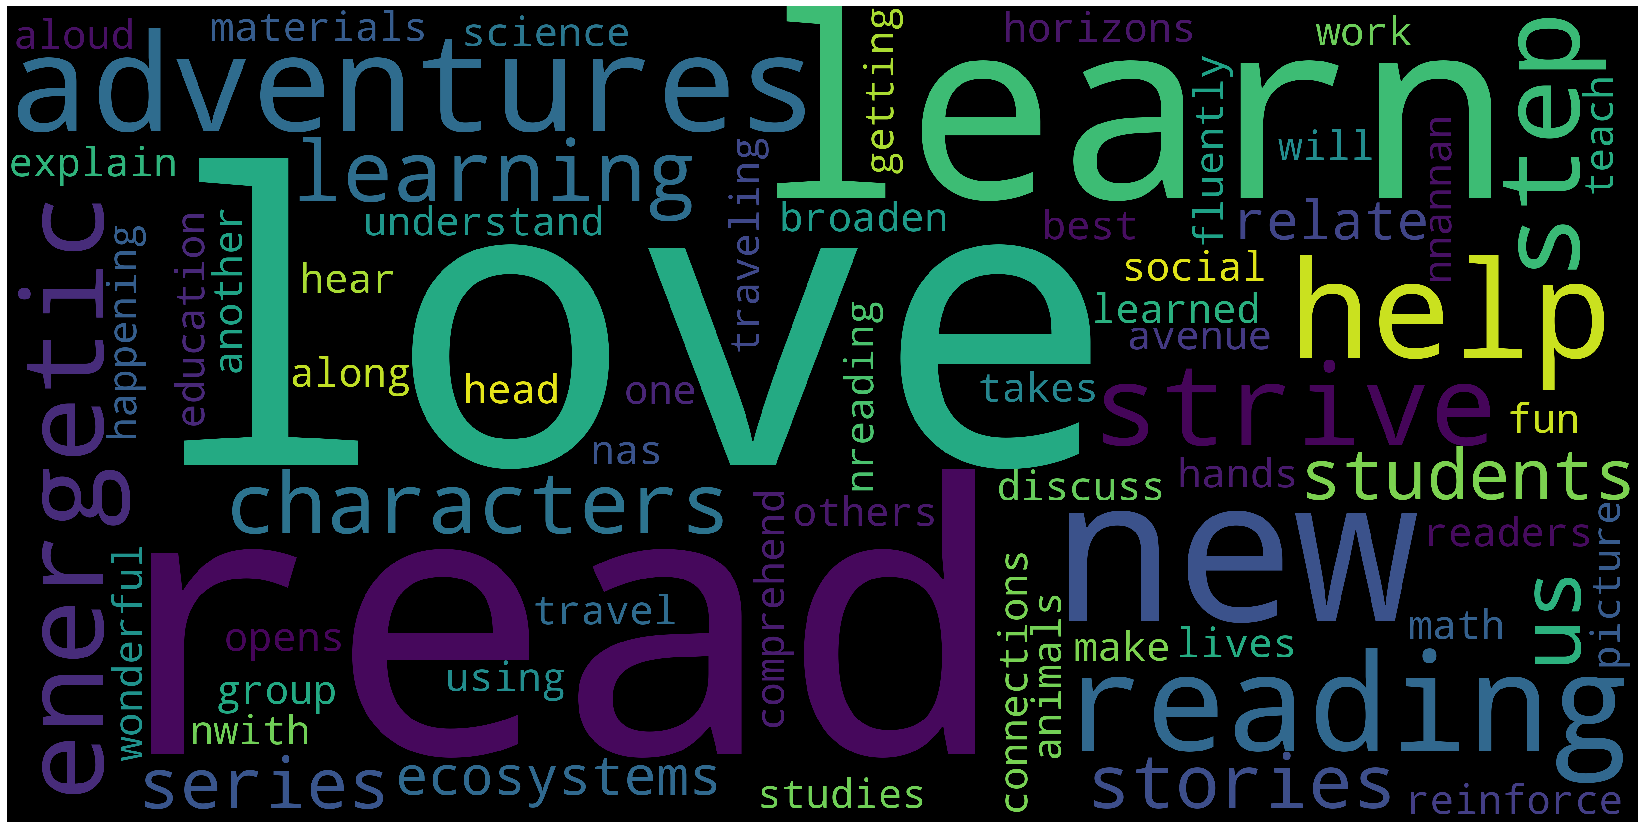

In [76]:
wc = WordCloud(width=5000,height=2500,background_color="black",stopwords=stopwords)
wc.generate(comment_words) 
plt.figure( figsize=(30,15)) 
plt.imshow(wc) 
plt.axis("off")
plt.show()

In [77]:
test_price_df = pd.DataFrame(X_test['price'])
fp_price_df = test_price_df.iloc[false_positives,:]
fp_price_df.head(5)

price
496    199.98
19356   40.59
23147   37.04
19171  537.97
31151  549.00

In [78]:
len(fp_price_df)

1287

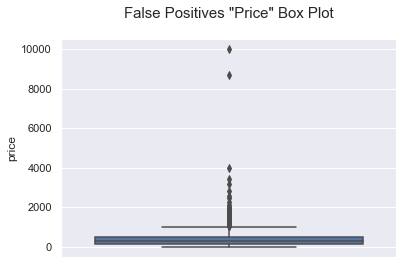

In [79]:
sns.boxplot(y='price', data=fp_price_df)
plt.title('False Positives "Price" Box Plot', size =15, y = 1.07)
plt.show()

In [80]:
test_nppp_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects'])
fp_nppp_df = test_nppp_df.iloc[false_positives,:]
fp_nppp_df.head(5)

teacher_number_of_previously_posted_projects
496                                              25
19356                                            16
23147                                             0
19171                                             6
31151                                             1

In [81]:
len(fp_nppp_df)

1287

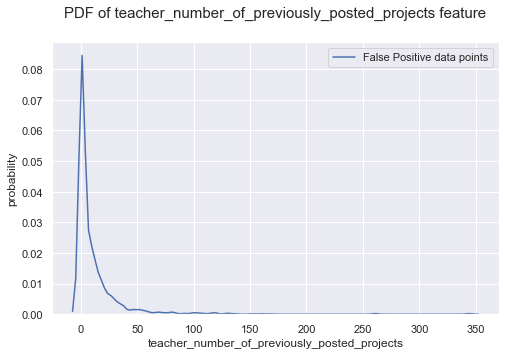

In [82]:
plt.figure(figsize=(8,5))
sns.distplot(fp_nppp_df.values, hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.title('PDF of teacher_number_of_previously_posted_projects feature', size =15, y = 1.07)
plt.show()

## Applying Decision Tree with obtained best Hyper parameter on TFIDF

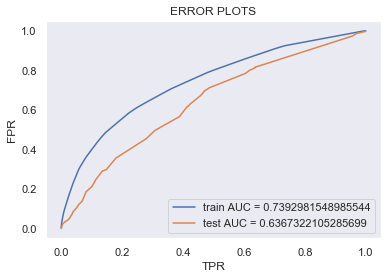

In [83]:
dt = DecisionTreeClassifier(max_depth= best_max_depth_tfidf, min_samples_split=best_min_samples_split_tfidf, class_weight =  "balanced")
dt.fit(X_train_tfidf_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(dt, X_train_tfidf_matrix)    
y_test_pred = batch_predict(dt, X_test_tfidf_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for TFIDF

the maximum value of tpr*(1-fpr) 0.45993831167164173 for threshold 0.463


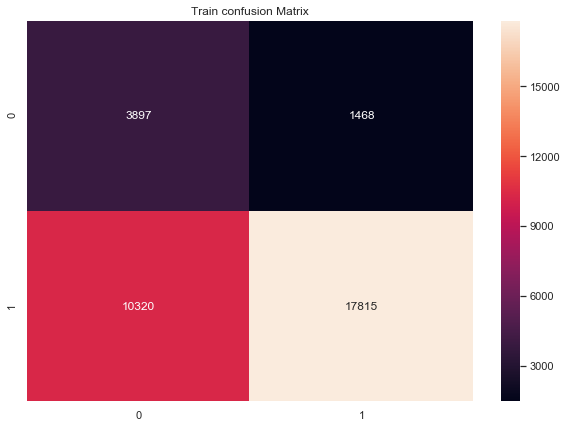

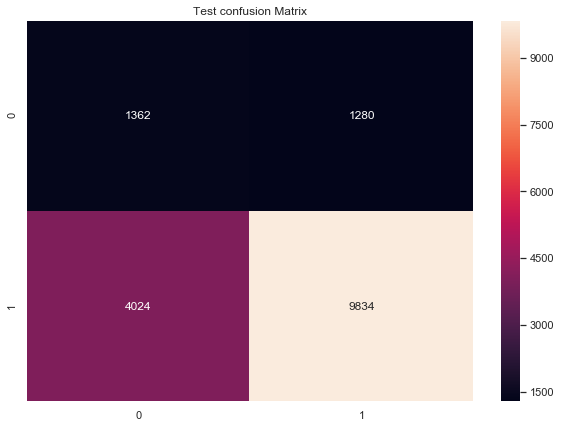

In [84]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

In [85]:
tfidf_features_names = []

for feature in vectorizer_cat.get_feature_names() :
    tfidf_features_names.append(feature)

for feature in vectorizer_subcat.get_feature_names() :
    tfidf_features_names.append(feature)

for feature in vectorizer_school_state.get_feature_names() :
    tfidf_features_names.append(feature)

for feature in vectorizer_grade.get_feature_names() :
    tfidf_features_names.append(feature)

for feature in vectorizer_prefix.get_feature_names() :
    tfidf_features_names.append(feature)

for feature in vectorizer_tfidf_title.get_feature_names() :
    tfidf_features_names.append(feature)
    
for feature in vectorizer_tfidf_essay.get_feature_names() :
    tfidf_features_names.append(feature)
    
for feature in vectorizer_tfidf_rs.get_feature_names() :
    tfidf_features_names.append(feature)
    
tfidf_features_names.append("price")
tfidf_features_names.append("quantity")
tfidf_features_names.append("teacher_number_of_previously_posted_projects")
tfidf_features_names.append('title_word_count')
tfidf_features_names.append('essay_word_count')
tfidf_features_names.append('essay_sentiment_score')

print('Number of feature are :',len(tfidf_features_names))

Number of feature are : 14122


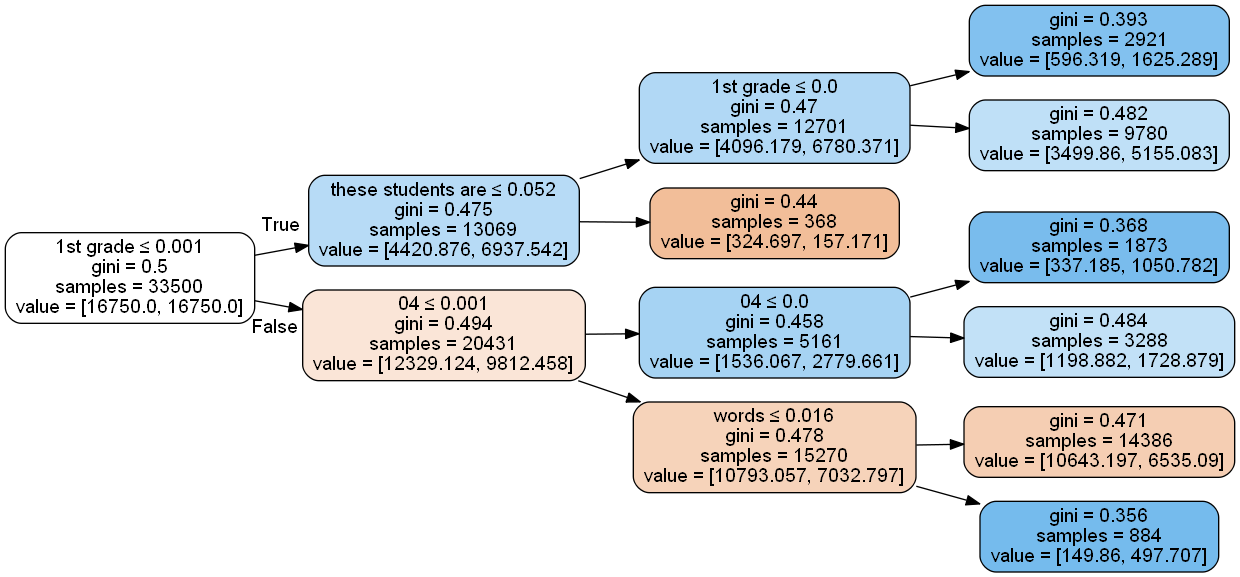

In [88]:
import warnings
import graphviz
warnings.filterwarnings("ignore")
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
from graphviz import Source
import pydotplus

dt = DecisionTreeClassifier(max_depth= 3, min_samples_split=best_min_samples_split_tfidf, class_weight =  "balanced")
dt.fit(X_train_tfidf_matrix, y_train)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=tfidf_features_names,rotate=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [89]:
predictions = predict_with_best_t(y_test_pred,best_t)
len(predictions)

16500

In [90]:
act_vs_predicted = pd.DataFrame({'index' : X_test.index, 'actual_label':y_test,'predicted_label':predictions})
act_vs_predicted.head(20)

index  actual_label  predicted_label
0   33818             1                1
1    6140             1                1
2   11555             1                0
3   23477             1                1
4   31007             1                0
5   49771             1                1
6   20399             1                1
7   35350             1                0
8   44517             1                1
9   33698             1                1
10   6332             1                1
11  15025             1                0
12  44119             1                1
13    496             0                1
14  19356             0                1
15  11569             1                0
16  23147             0                1
17   4775             1                1
18  25411             1                1
19   2472             1                1

In [91]:
false_positives = []
for i in tqdm(range(len(act_vs_predicted))):
    if(act_vs_predicted['actual_label'][i]==0 and act_vs_predicted['predicted_label'][i]==1 ):
        false_positives.append(i)

len(false_positives)

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 87535.29it/s]


1280

In [92]:
false_positives_essay = []
for i in false_positives :
    false_positives_essay.append(X_test['essay'].values[i])

In [93]:
false_positives_essay[0]

'My students are eager, not only for musical knowledge, but for playing musical instrument as well.Presently, I teach elementary/middle school music (4-8) at a high needs public school in Illinois. Due to budget cuts, the school is unable to fund a music program for the school. Music, being an interdisciplinary subject, encompasses all subjects students encounter during their education. The students at this school are very enthusiastic about music and should have a top-notch music program. This can only be possible with your help!The students will learn how to work together in an ensemble which encourages team work. They will also receive the satisfaction of learning how to play a musical instrument. Music is very entertaining and allows for freedom of expression. My students deserve the opportunity to express themselves through music, and playing the trumpet will provide that foundation.Music is the universal language, and provides an experience that will allow the students to appreci

In [94]:
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_positives_essay :
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens :
    comment_words = comment_words + words + ' '

In [95]:
len(comment_words)

1095

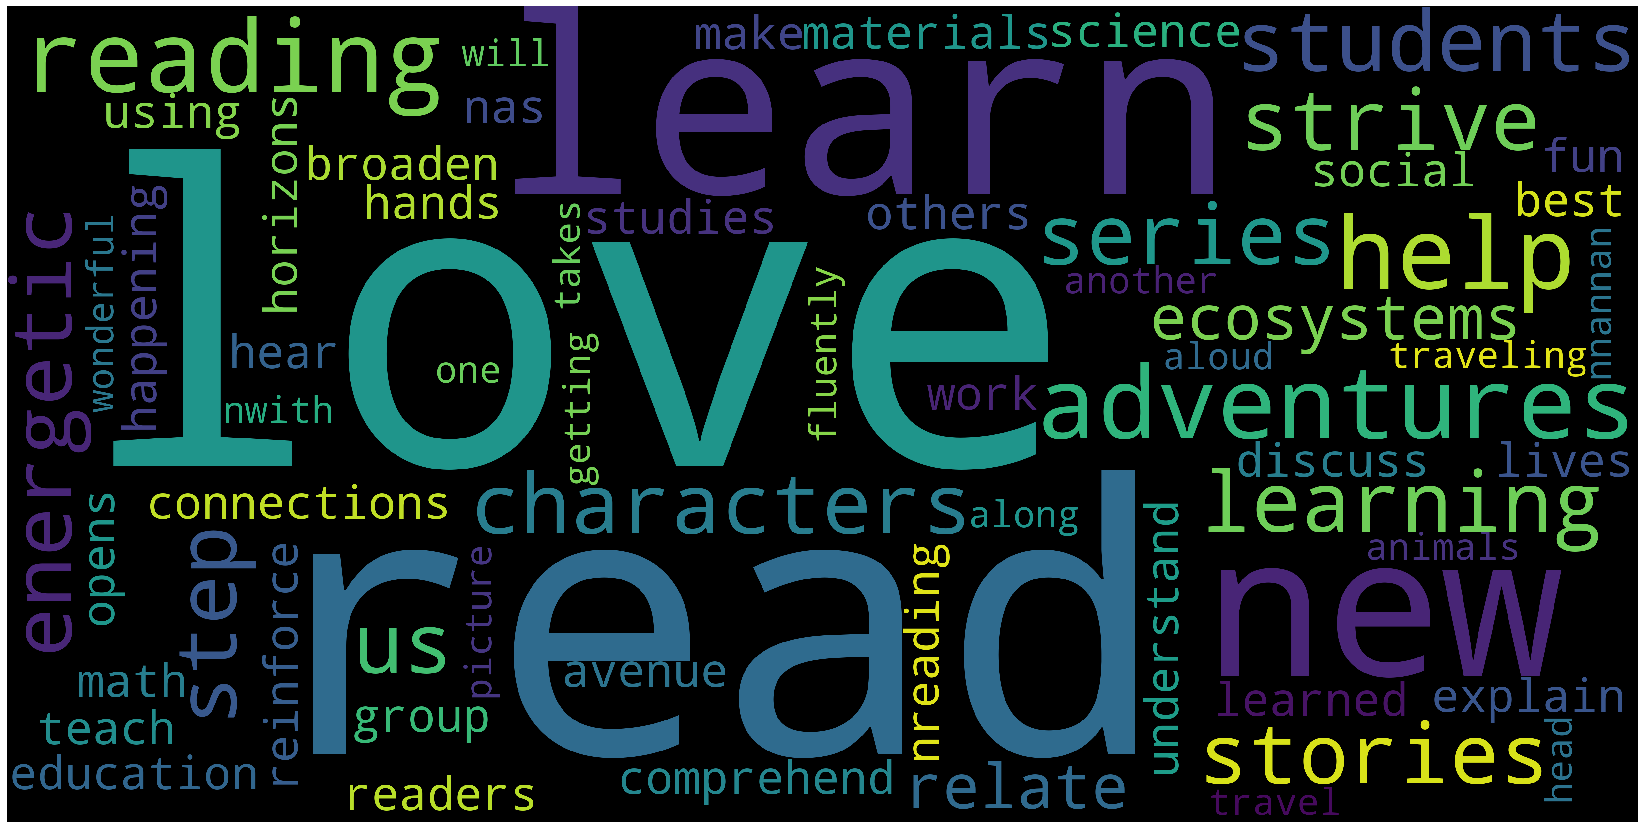

In [96]:
wc = WordCloud(width=5000,height=2500,background_color="black",stopwords=stopwords)
wc.generate(comment_words) 
plt.figure( figsize=(30,15)) 
plt.imshow(wc) 
plt.axis("off")
plt.show()

In [97]:
test_price_df = pd.DataFrame(X_test['price'])
fp_price_df = test_price_df.iloc[false_positives,:]
fp_price_df.head(5)

price
496    199.98
19356   40.59
23147   37.04
19171  537.97
31151  549.00

In [98]:
len(fp_price_df)

1280

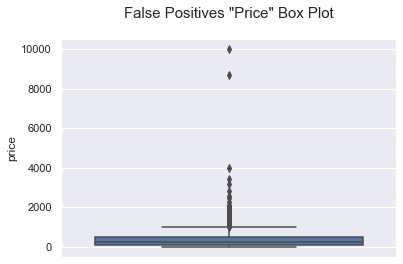

In [99]:
sns.boxplot(y='price', data=fp_price_df)
plt.title('False Positives "Price" Box Plot', size =15, y = 1.07)
plt.show()

In [100]:
test_nppp_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects'])
fp_nppp_df = test_nppp_df.iloc[false_positives,:]
fp_nppp_df.head(5)

teacher_number_of_previously_posted_projects
496                                              25
19356                                            16
23147                                             0
19171                                             6
31151                                             1

In [101]:
len(fp_nppp_df)

1280

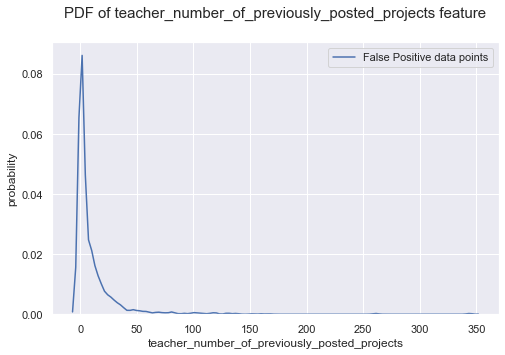

In [102]:
plt.figure(figsize=(8,5))
sns.distplot(fp_nppp_df.values, hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.title('PDF of teacher_number_of_previously_posted_projects feature', size =15, y = 1.07)
plt.show()

## Applying Decision Tree with obtained best Hyper parameter on AVG W2V representation

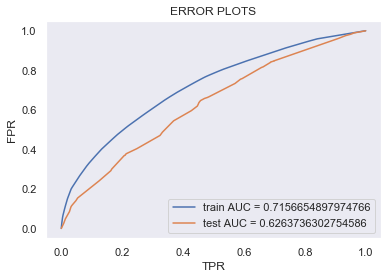

In [103]:
dt = DecisionTreeClassifier(max_depth= best_max_depth_aw2v, min_samples_split=best_min_samples_split_aw2v, class_weight =  "balanced")
dt.fit(X_train_aw2v_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(dt, X_train_aw2v_matrix)    
y_test_pred = batch_predict(dt, X_test_aw2v_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for AVG W2V

the maximum value of tpr*(1-fpr) 0.42867708629558815 for threshold 0.516


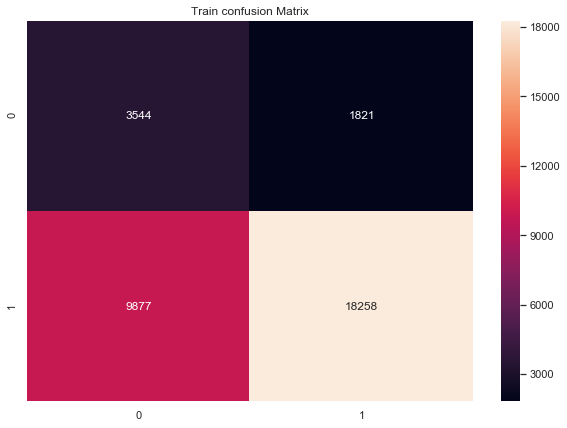

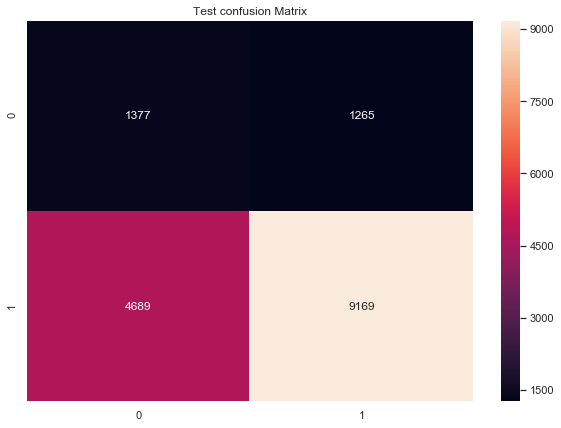

In [104]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

In [105]:
predictions = predict_with_best_t(y_test_pred,best_t)
len(predictions)

16500

In [106]:
act_vs_predicted = pd.DataFrame({'index' : X_test.index, 'actual_label':y_test,'predicted_label':predictions})
act_vs_predicted.head(20)

index  actual_label  predicted_label
0   33818             1                1
1    6140             1                1
2   11555             1                0
3   23477             1                1
4   31007             1                1
5   49771             1                0
6   20399             1                0
7   35350             1                1
8   44517             1                1
9   33698             1                1
10   6332             1                1
11  15025             1                0
12  44119             1                0
13    496             0                1
14  19356             0                1
15  11569             1                0
16  23147             0                1
17   4775             1                1
18  25411             1                0
19   2472             1                1

In [107]:
false_positives = []
for i in tqdm(range(len(act_vs_predicted))):
    if(act_vs_predicted['actual_label'][i]==0 and act_vs_predicted['predicted_label'][i]==1 ):
        false_positives.append(i)

len(false_positives)

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 82721.07it/s]


1265

In [108]:
false_positives_essay = []
for i in false_positives :
    false_positives_essay.append(X_test['essay'].values[i])

In [109]:
false_positives_essay[0]

'My students are eager, not only for musical knowledge, but for playing musical instrument as well.Presently, I teach elementary/middle school music (4-8) at a high needs public school in Illinois. Due to budget cuts, the school is unable to fund a music program for the school. Music, being an interdisciplinary subject, encompasses all subjects students encounter during their education. The students at this school are very enthusiastic about music and should have a top-notch music program. This can only be possible with your help!The students will learn how to work together in an ensemble which encourages team work. They will also receive the satisfaction of learning how to play a musical instrument. Music is very entertaining and allows for freedom of expression. My students deserve the opportunity to express themselves through music, and playing the trumpet will provide that foundation.Music is the universal language, and provides an experience that will allow the students to appreci

In [110]:
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_positives_essay :
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens :
    comment_words = comment_words + words + ' '

In [111]:
len(comment_words)

1095

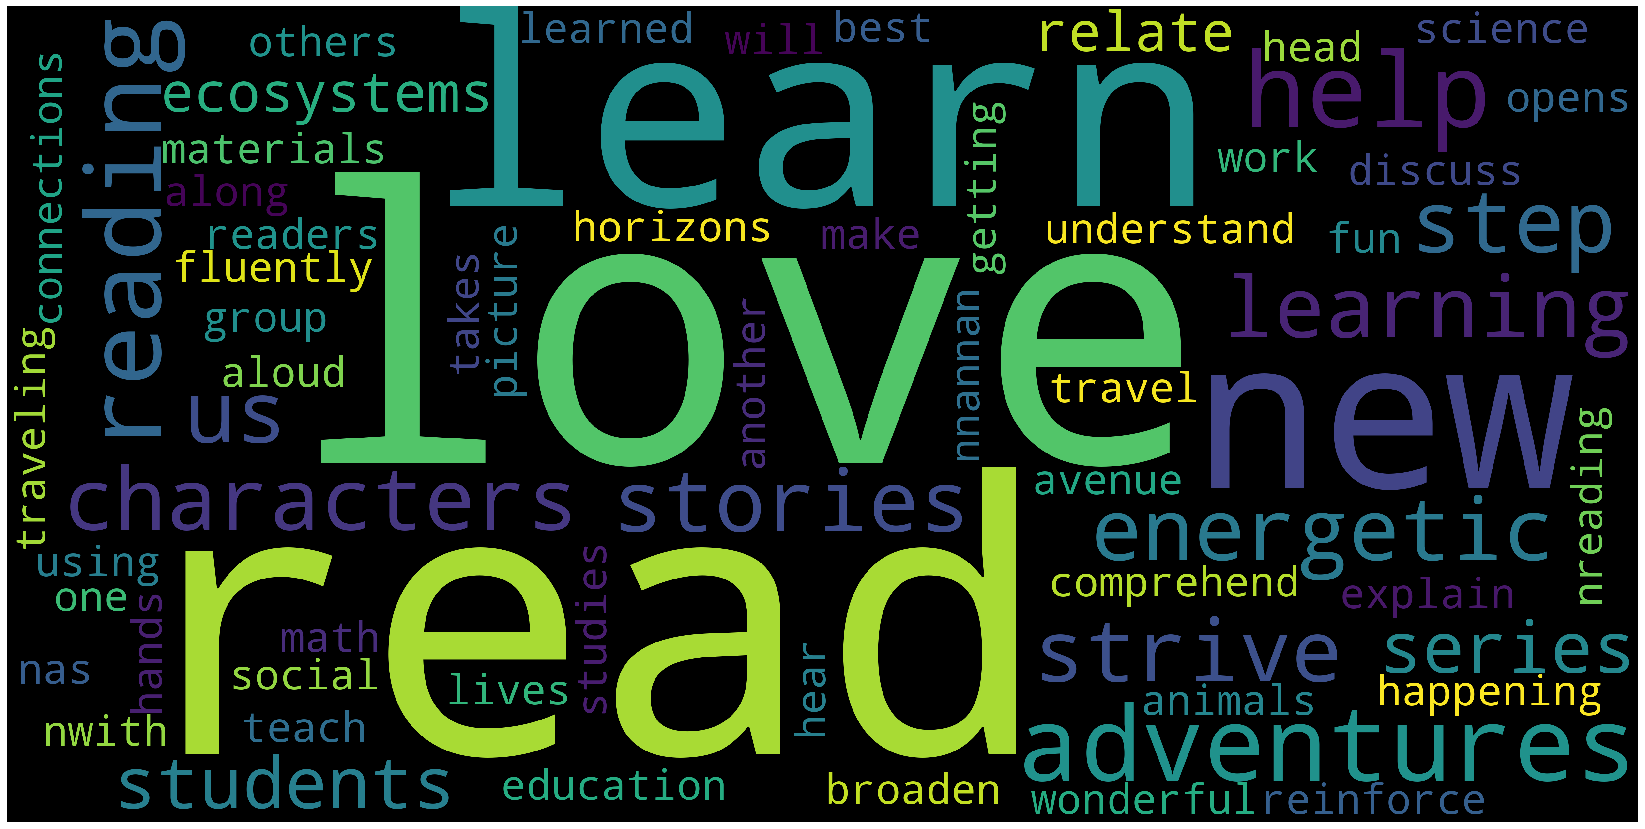

In [112]:
wc = WordCloud(width=5000,height=2500,background_color="black",stopwords=stopwords)
wc.generate(comment_words) 
plt.figure( figsize=(30,15)) 
plt.imshow(wc) 
plt.axis("off")
plt.show()

In [113]:
test_price_df = pd.DataFrame(X_test['price'])
fp_price_df = test_price_df.iloc[false_positives,:]
fp_price_df.head(5)

price
496    199.98
19356   40.59
23147   37.04
26897   93.90
19171  537.97

In [114]:
len(fp_price_df)

1265

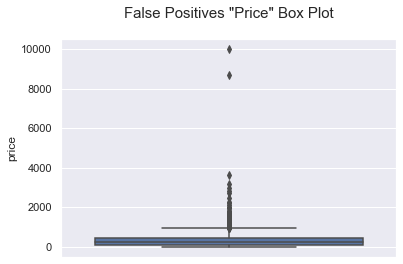

In [115]:
sns.boxplot(y='price', data=fp_price_df)
plt.title('False Positives "Price" Box Plot', size =15, y = 1.07)
plt.show()

In [116]:
test_nppp_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects'])
fp_nppp_df = test_nppp_df.iloc[false_positives,:]
fp_nppp_df.head(5)

teacher_number_of_previously_posted_projects
496                                              25
19356                                            16
23147                                             0
26897                                             3
19171                                             6

In [117]:
len(fp_nppp_df)

1265

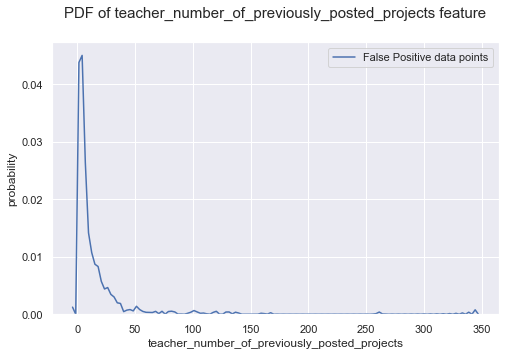

In [118]:
plt.figure(figsize=(8,5))
sns.distplot(fp_nppp_df.values, hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.title('PDF of teacher_number_of_previously_posted_projects feature', size =15, y = 1.07)
plt.show()

## Applying Decision Tree with obtained best Hyper parameter on TFIDF W2V representation

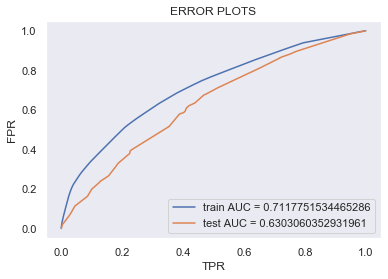

In [119]:
dt = DecisionTreeClassifier(max_depth= best_max_depth_tw2v, min_samples_split=best_min_samples_split_tw2v, class_weight =  "balanced")
dt.fit(X_train_tw2v_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(dt, X_train_tw2v_matrix)    
y_test_pred = batch_predict(dt, X_test_tw2v_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for TFIDF W2V

the maximum value of tpr*(1-fpr) 0.42913883285735743 for threshold 0.505


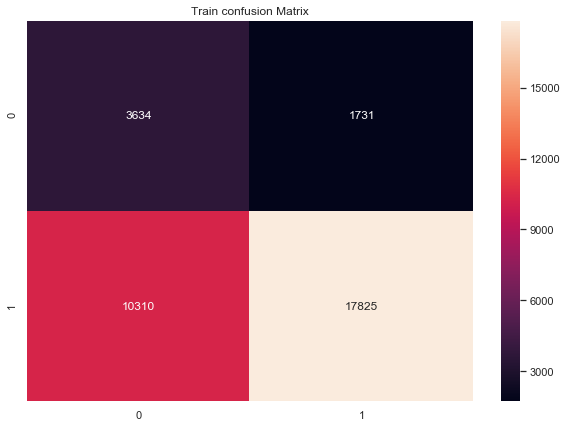

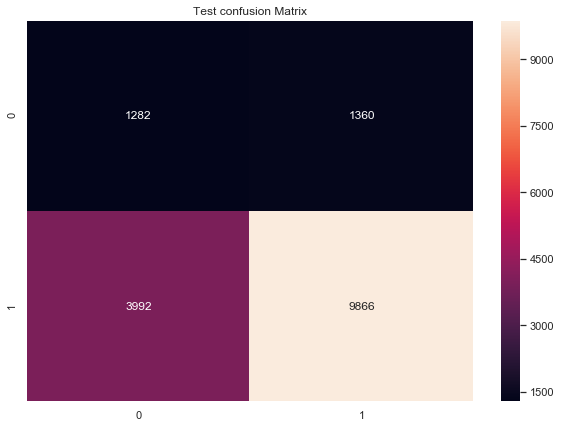

In [120]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

In [121]:
predictions = predict_with_best_t(y_test_pred,best_t)
len(predictions)

16500

In [122]:
act_vs_predicted = pd.DataFrame({'index' : X_test.index, 'actual_label':y_test,'predicted_label':predictions})
act_vs_predicted.head(20)

index  actual_label  predicted_label
0   33818             1                1
1    6140             1                0
2   11555             1                0
3   23477             1                1
4   31007             1                0
5   49771             1                0
6   20399             1                1
7   35350             1                1
8   44517             1                1
9   33698             1                1
10   6332             1                1
11  15025             1                0
12  44119             1                1
13    496             0                1
14  19356             0                1
15  11569             1                0
16  23147             0                1
17   4775             1                1
18  25411             1                1
19   2472             1                1

In [123]:
false_positives = []
for i in tqdm(range(len(act_vs_predicted))):
    if(act_vs_predicted['actual_label'][i]==0 and act_vs_predicted['predicted_label'][i]==1 ):
        false_positives.append(i)

len(false_positives)

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 86421.42it/s]


1360

In [124]:
false_positives_essay = []
for i in false_positives :
    false_positives_essay.append(X_test['essay'].values[i])

In [125]:
false_positives_essay[0]

'My students are eager, not only for musical knowledge, but for playing musical instrument as well.Presently, I teach elementary/middle school music (4-8) at a high needs public school in Illinois. Due to budget cuts, the school is unable to fund a music program for the school. Music, being an interdisciplinary subject, encompasses all subjects students encounter during their education. The students at this school are very enthusiastic about music and should have a top-notch music program. This can only be possible with your help!The students will learn how to work together in an ensemble which encourages team work. They will also receive the satisfaction of learning how to play a musical instrument. Music is very entertaining and allows for freedom of expression. My students deserve the opportunity to express themselves through music, and playing the trumpet will provide that foundation.Music is the universal language, and provides an experience that will allow the students to appreci

In [126]:
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_positives_essay :
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens :
    comment_words = comment_words + words + ' '

In [127]:
len(comment_words)

2803

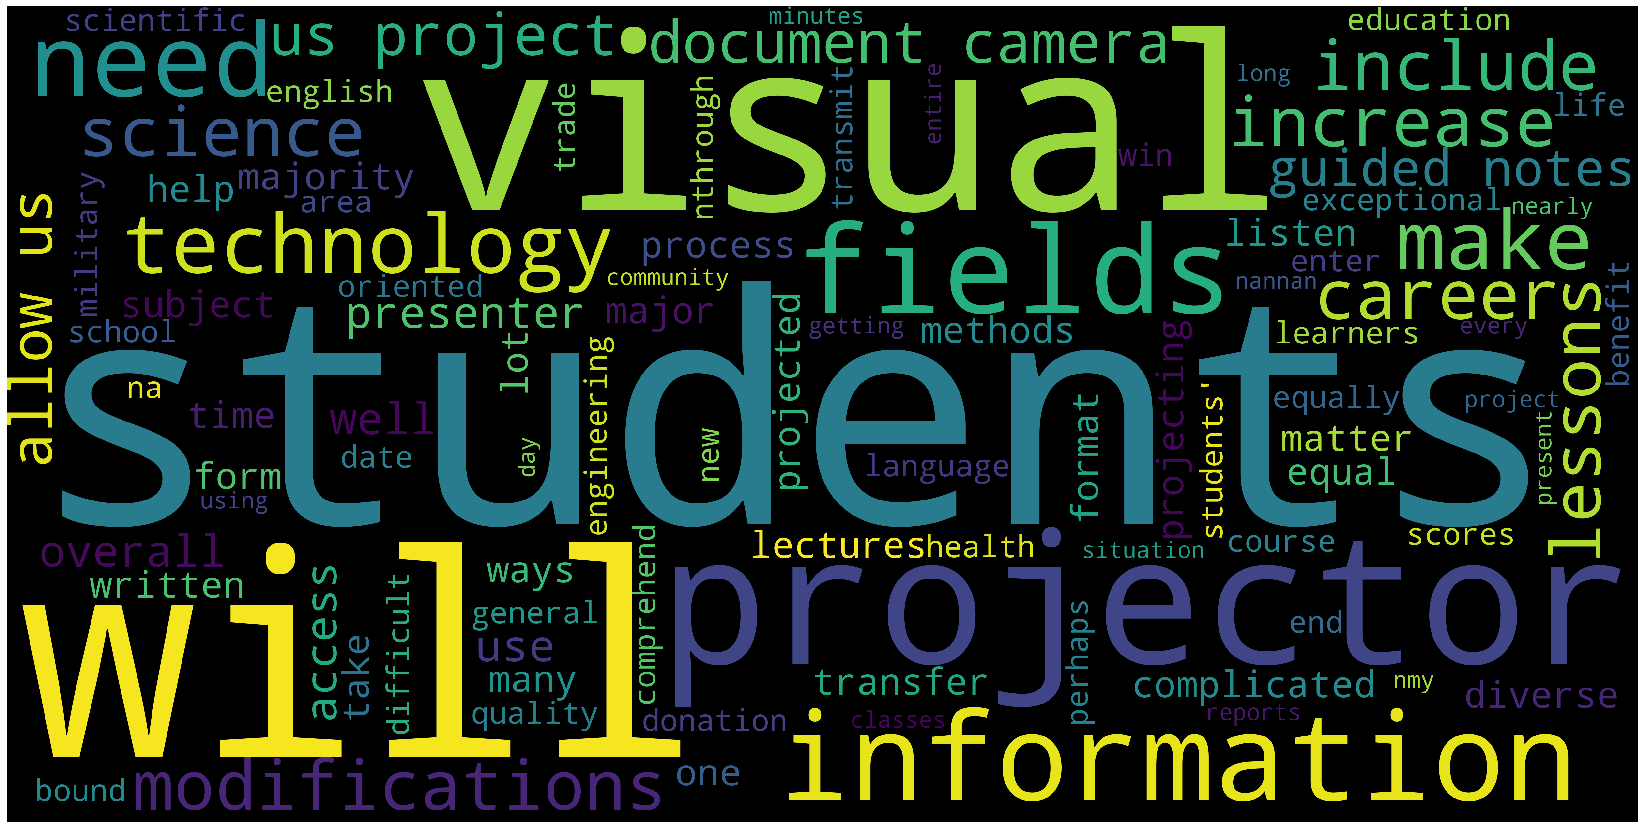

In [128]:
wc = WordCloud(width=5000,height=2500,background_color="black",stopwords=stopwords)
wc.generate(comment_words) 
plt.figure( figsize=(30,15)) 
plt.imshow(wc) 
plt.axis("off")
plt.show()

In [129]:
test_price_df = pd.DataFrame(X_test['price'])
fp_price_df = test_price_df.iloc[false_positives,:]
fp_price_df.head(5)

price
496    199.98
19356   40.59
23147   37.04
19171  537.97
31151  549.00

In [130]:
len(fp_price_df)

1360

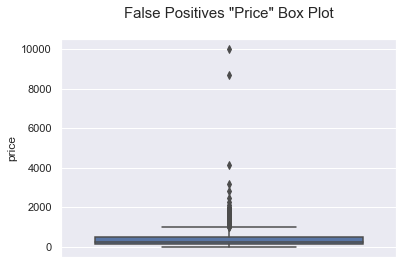

In [131]:
sns.boxplot(y='price', data=fp_price_df)
plt.title('False Positives "Price" Box Plot', size =15, y = 1.07)
plt.show()

In [132]:
test_nppp_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects'])
fp_nppp_df = test_nppp_df.iloc[false_positives,:]
fp_nppp_df.head(5)

teacher_number_of_previously_posted_projects
496                                              25
19356                                            16
23147                                             0
19171                                             6
31151                                             1

In [133]:
len(fp_nppp_df)

1360

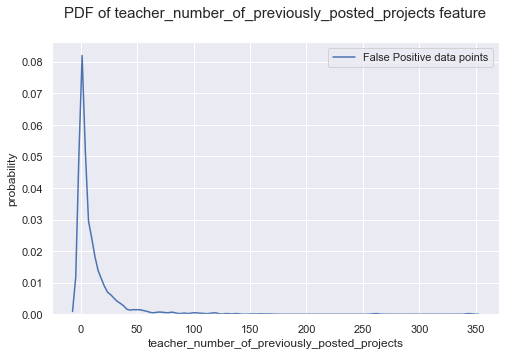

In [134]:
plt.figure(figsize=(8,5))
sns.distplot(fp_nppp_df.values, hist=False, label="False Positive data points")
plt.title('PDF with the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('probability')
plt.legend()
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.title('PDF of teacher_number_of_previously_posted_projects feature', size =15, y = 1.07)
plt.show()

## Task-2 

In [135]:
print(X_train_tfidf_matrix.shape)
print(X_test_tfidf_matrix.shape)

(33500, 14122)
(16500, 14122)


In [136]:
def selectKImportance(model, X, k):
     return X[:,model.feature_importances_.argsort()[::-1][:k]]

In [137]:
dt = DecisionTreeClassifier(max_depth= best_max_depth_tfidf, min_samples_split=best_min_samples_split_tfidf, class_weight =  "balanced")
dt.fit(X_train_tfidf_matrix, y_train)
X_train_5k_features = selectKImportance(dt, X_train_tfidf_matrix, 5000)
X_test_5k_features = selectKImportance(dt, X_test_tfidf_matrix, 5000)

In [138]:
print('After selecting top 5K features, the shape of train matrix is',X_train_5k_features.shape)
print('After selecting top 5K features, the shape of test matrix is',X_test_5k_features.shape)

After selecting top 5K features, the shape of train matrix is (33500, 5000)
After selecting top 5K features, the shape of test matrix is (16500, 5000)


## Applying Logistic Regression on top 5K features of TFIDF Matrix

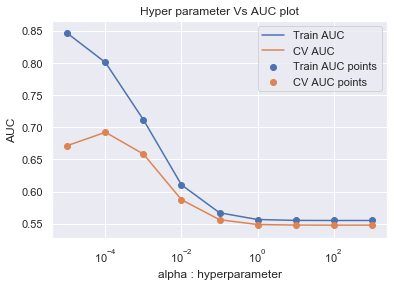

In [139]:

from sklearn import linear_model

parameters = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,10**2,10**3]}
lg = linear_model.SGDClassifier(loss='log', class_weight =  "balanced" )
clf = GridSearchCV(lg, parameters, cv=10, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_5k_features, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_alpha']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid(True)
plt.show()

In [140]:
best_alpha = clf.best_params_['alpha']
best_alpha

0.0001

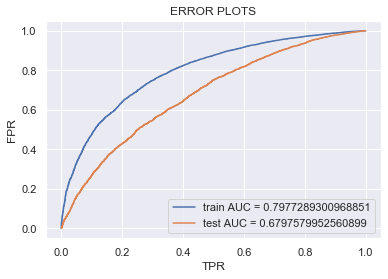

In [141]:
clf = linear_model.SGDClassifier(loss = 'log', alpha = best_alpha, class_weight =  "balanced")
clf.fit(X_train_5k_features, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_train_5k_features)    
y_test_pred = batch_predict(clf, X_test_5k_features)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.show()

## Confusion Matrix with predicted and original labels

the maximum value of tpr*(1-fpr) 0.5271472137648148 for threshold 0.494


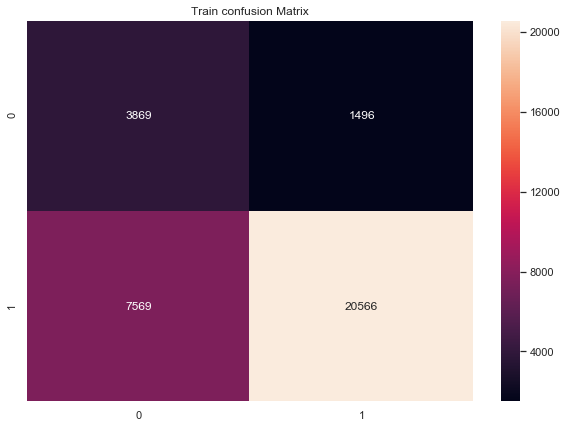

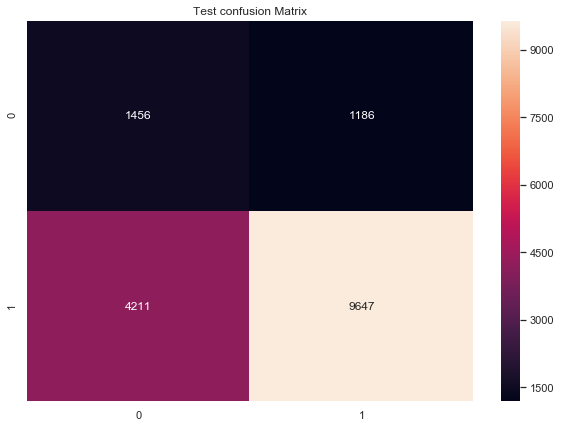

In [142]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

## Conclusion

In [143]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

table.add_row(['BOW', 'Decision Trees', ('Max Depth = '+str(best_max_depth_bow) + ', Min Samples = '+str(best_min_samples_split_bow)), 0.6501])
table.add_row(['TFIDF', 'Decision Trees', ('Max Depth = '+str(best_max_depth_tfidf) + ', Min Samples = '+str(best_min_samples_split_tfidf)), 0.6367])
table.add_row(['AVG W2V', 'Decision Trees', ('Max Depth = '+str(best_max_depth_aw2v) + ', Min Samples = '+str(best_min_samples_split_aw2v)), 0.6263])
table.add_row(['TFIDF W2V', 'Decision Trees', ('Max Depth = '+str(best_max_depth_tw2v) + ', Min Samples = '+str(best_min_samples_split_tw2v)), 0.6303])
table.add_row(['TFIDF with 5K Features', 'Logistic Regression', ('Alpha = '+str(best_alpha)), 0.6797])
print(table)


+------------------------+---------------------+----------------------------------+--------+
|       Vectorizer       |        Model        |         Hyper Parameter          |  AUC   |
+------------------------+---------------------+----------------------------------+--------+
|          BOW           |    Decision Trees   | Max Depth = 8, Min Samples = 500 | 0.6501 |
|         TFIDF          |    Decision Trees   | Max Depth = 8, Min Samples = 500 | 0.6367 |
|        AVG W2V         |    Decision Trees   | Max Depth = 6, Min Samples = 500 | 0.6263 |
|       TFIDF W2V        |    Decision Trees   | Max Depth = 6, Min Samples = 500 | 0.6303 |
| TFIDF with 5K Features | Logistic Regression |          Alpha = 0.0001          | 0.6797 |
+------------------------+---------------------+----------------------------------+--------+


# Summary

* BOW vectorizer gave AUC 0.6501 with Max Depth = 8, Min Samples = 500
* TFIDF vectorizer gave AUC 0.6367 with Max Depth = 8, Min Samples = 500
* AVG W2V vectorizer gave AUC 0.6263 with Max Depth = 6, Min Samples = 500
* TFIDF W2V vectorizer gave AUC 0.6303 with Max Depth = 6, Min Samples = 500
* TFIDF with 5K Features vectorizer gave AUC 0.6797 with Logistic Regression and best hyper parameter Alpha = 0.0001
* BOW vectorizer has the best AUC
* TFIDF, TFIDF W2V and AVG W2V has the next best AUC respectively
* TFIDF AUC raised from 0.6367 to 0.6797 when Logistic Regression with 5K Features is used instead of Decision Trees